## POS tagging using modified Viterbi

### Problem Statement

You have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

 

In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?
 

You have been given a 'test' file below containing some sample sentences with unknown words. Look at the sentences and try to observe rules which may be useful to tag unknown words. Your final model will be evaluated on a similar test file.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
## set the pandas option to display all rows
pd.set_option('display.max_rows',None)

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
## write the treebank corpus to a file
with open('treebankuniversal.txt', 'w') as f:
    for item in nltk_data:
        f.write("%s\n" % item)

In [5]:
# print few sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
# Splitting into train and test with 95% in traina and 5% in validation set
train_set, valid_set = train_test_split(nltk_data,test_size=0.05,random_state=100)

print(len(train_set))
print(len(valid_set))
print(train_set[:40])

3718
196
[[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET'), ('third', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('ringers', 'NOUN'), ('today', 'NOUN'), ('are', 'VERB'), ('women', 'NOUN'), ('.', '.')], [('``', '.'), ('These', 'DET'), ('days', 'NOUN'), (',', '.'), ('banking', 'NOUN'), ('customers', 'NOUN'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('door', 'NOUN'), ('*-1', 'X'), ('expecting', 'VERB'), ('you', 'PRON'), ('to', 'PRT'), ('have', 'VERB'), ('a', 'DET'), ('package', 'NOUN'), ('especially', 'ADV'), ('for', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('Ms.', 'NOUN'), ('Moore', 'NOUN'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.')], [('The', 'DET'), ('rights', 'NOUN'), (

In [7]:
# Get list of tagged words from train set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95949

In [8]:
# get the words from the train set
words = [pair[0] for pair in train_tagged_words]
words[:10]

['One',
 'bright',
 'sign',
 'is',
 'that',
 'a',
 'growing',
 'number',
 'of',
 'women']

In [9]:
# get the vocabulary
V = set(words)
print(len(V))

12106


In [10]:
# get the tags from the train set
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
## display the tags
print(T)

{'PRON', 'X', 'ADJ', 'VERB', 'ADV', 'PRT', '.', 'DET', 'ADP', 'NOUN', 'NUM', 'CONJ'}


### Emission Probabilities

Define function to calculate the emission probability given word, tag

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

Define function to calculate the transition probability for a tag given another tag and create the transition probability matrix

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus tags_matrix(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
## display the tags matrix
tags_matrix

array([[7.66283507e-03, 9.27203074e-02, 7.20306486e-02, 4.84291196e-01,
        3.40996161e-02, 1.22605367e-02, 4.06130254e-02, 9.19540226e-03,
        2.33716480e-02, 2.11494252e-01, 7.27969361e-03, 4.98084305e-03],
       [5.57054430e-02, 7.44326264e-02, 1.65053159e-02, 2.04570696e-01,
        2.53927950e-02, 1.84891284e-01, 1.62831292e-01, 5.52293286e-02,
        1.44897640e-01, 6.23710528e-02, 2.85668951e-03, 1.03158224e-02],
       [4.91400482e-04, 2.03112196e-02, 6.71580657e-02, 1.17936116e-02,
        4.91400482e-03, 1.01556098e-02, 6.38820603e-02, 4.91400482e-03,
        7.86240771e-02, 7.00900912e-01, 2.08026208e-02, 1.60524156e-02],
       [3.59160937e-02, 2.18437955e-01, 6.56397566e-02, 1.68743715e-01,
        8.20496976e-02, 3.14265825e-02, 3.42905782e-02, 1.33292049e-01,
        9.11835283e-02, 1.11386329e-01, 2.24475581e-02, 5.18616010e-03],
       [1.56458057e-02, 2.33022645e-02, 1.30159780e-01, 3.44540626e-01,
        7.72303566e-02, 1.43142473e-02, 1.35153130e-01, 6.99

In [16]:
# convert the matrix to a df 
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
## display the tags_df
tags_df

,PRON,X,ADJ,VERB,ADV,PRT,.,DET,ADP,NOUN,NUM,CONJ
PRON,0.007663,0.092720,0.072031,0.484291,0.034100,0.012261,0.040613,0.009195,0.023372,0.211494,0.007280,0.004981
X,0.055705,0.074433,0.016505,0.204571,0.025393,0.184891,0.162831,0.055229,0.144898,0.062371,0.002857,0.010316
ADJ,0.000491,0.020311,0.067158,0.011794,0.004914,0.010156,0.063882,0.004914,0.078624,0.700901,0.020803,0.016052
VERB,0.035916,0.218438,0.065640,0.168744,0.082050,0.031427,0.034291,0.133292,0.091184,0.111386,0.022448,0.005186
ADV,0.015646,0.023302,0.130160,0.344541,0.077230,0.014314,0.135153,0.069907,0.119507,0.031624,0.031624,0.006991
PRT,0.017717,0.013123,0.083661,0.405184,0.010171,0.001969,0.043635,0.101050,0.019357,0.245735,0.056102,0.002297
.,0.065208,0.026908,0.043681,0.088708,0.052292,0.002511,0.092923,0.173558,0.092206,0.222531,0.081353,0.058032
DET,0.003727,0.045323,0.204977,0.040394,0.012623,0.000240,0.017913,0.005771,0.009618,0.637293,0.021640,0.000481
ADP,0.069119,0.034984,0.107389,0.008481,0.013357,0.001484,0.039754,0.323969,0.017492,0.321213,0.061910,0.000848
NOUN,0.004721,0.028868,0.012165,0.146955,0.016813,0.043357,0.239951,0.013363,0.177058,0.264280,0.009550,0.042921


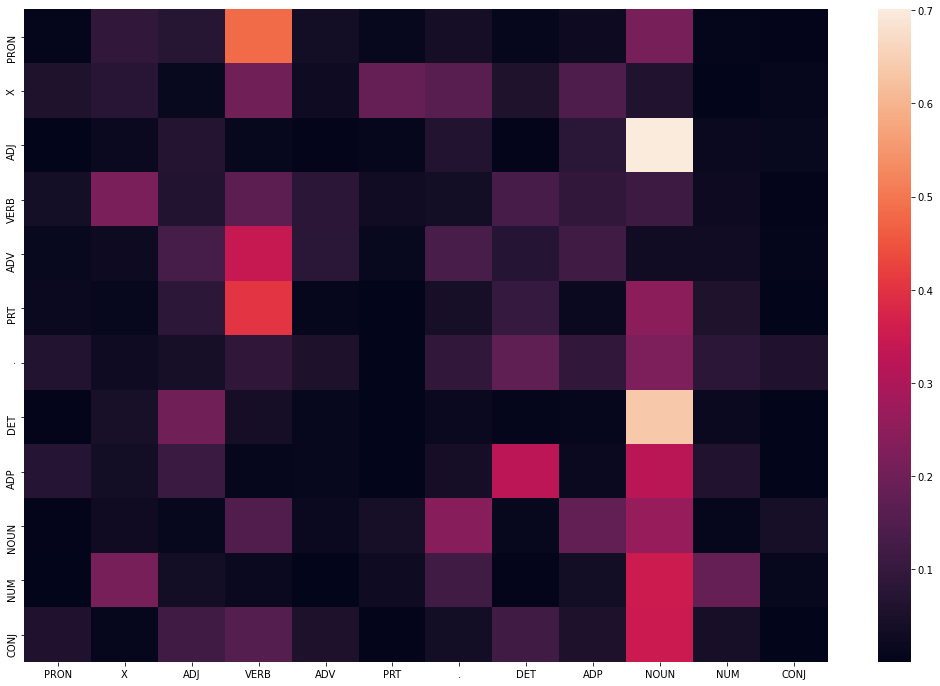

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


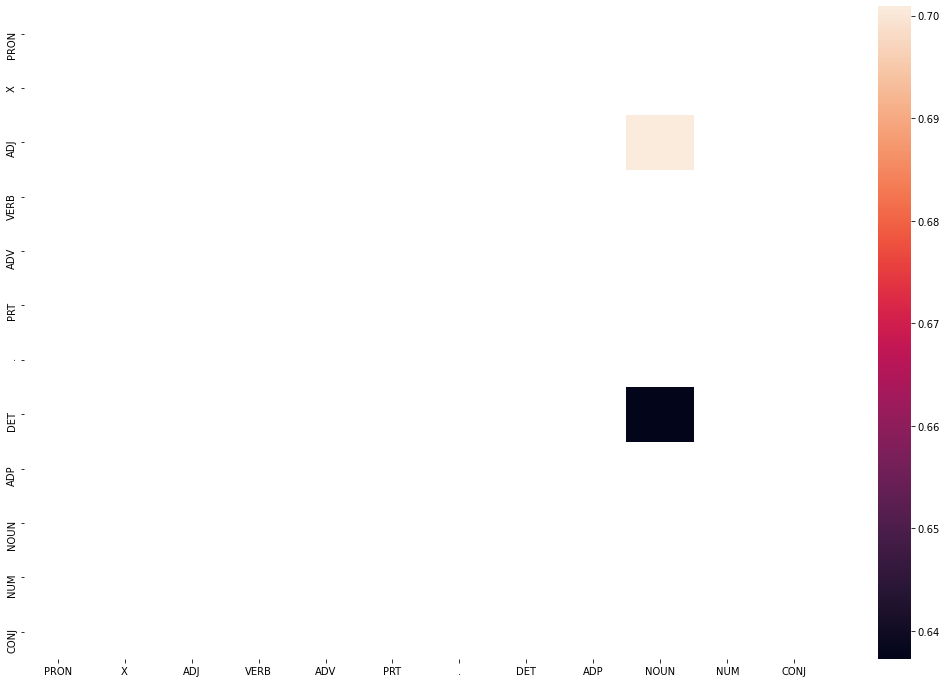

In [19]:
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Vanilla Viterbi based POS tagger

In [20]:
## print the length of train tagged words
len(train_tagged_words)

95949

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Evaluating on Validation Set

In [22]:
# Running on entire validation dataset

valid_run = valid_set

# list of tagged words
valid_run_base = [tup for sent in valid_run for tup in sent]

# list of untagged words
valid_tagged_words = [tup[0] for sent in valid_run for tup in sent]
valid_run[0]

[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('book', 'VERB'),
 ('some', 'DET'),
 ('profits', 'NOUN'),
 ('yesterday', 'NOUN'),
 (',', '.'),
 ('*-1', 'X'),
 ('leaving', 'VERB'),
 ('stocks', 'ADV'),
 ('up', 'ADP'),
 ('fractionally', 'ADV'),
 ('.', '.')]

In [23]:
# tagging the validation sentences using the Vanilla Viterbi
start = time.time()
tagged_seq = Viterbi(valid_tagged_words)
end = time.time()
difference = end-start

In [24]:
## write the vanilla viterbi output to a file
import pickle
with open('vanillaviterbi.txt', 'wb') as fh:
    pickle.dump(tagged_seq, fh)

In [25]:
##  read the vanilla viterbi details from the file
import pickle
pickle_off = open ('vanillaviterbi.txt', "rb")
tagged_seq = pickle.load(pickle_off)

In [26]:
## print the predicted POS tags
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  816.3468096256256
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'PRON'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'VERB'), (',', '.'), ('an', 'DET'), ('analyst', 'NOUN')

In [27]:
# check the accuracy 
check = [i for i, j in zip(tagged_seq, valid_run_base) if i == j] 

In [28]:
## calculate the accuracy
accuracy = len(check)/len(tagged_seq)

In [29]:
## print the accuracy
accuracy

0.9022635921303153

In [30]:
## get the incorrect tagged words
incorrect_tagged_cases = [[valid_run_base[i-1],j[0],j[1]] for i, j in enumerate(zip(tagged_seq, valid_run_base)) if j[0]!=j[1]]

In [31]:
## create a dataframe with the incorrect tagged words
col_names = ['Prev_Word','Prev_Tag','Tagged_Word','Tagged_POS','Expected_Word','Expected_Tag']
df_pos_tagged = pd.DataFrame([[item for tup in x for item in tup] for x in incorrect_tagged_cases], columns=col_names)
df_pos_tagged

,Prev_Word,Prev_Tag,Tagged_Word,Tagged_POS,Expected_Word,Expected_Tag
0,to,PRT,book,NOUN,book,VERB
1,leaving,VERB,stocks,NOUN,stocks,ADV
2,stocks,ADV,up,PRT,up,ADP
3,carried,VERB,over,ADP,over,PRT
4,apparently,ADV,ignored,PRON,ignored,VERB
5,Chilean,ADJ,mine,NOUN,mine,ADJ
6,the,DET,Palestinian,ADJ,Palestinian,NOUN
7,committee,NOUN,first,ADJ,first,ADV
8,.,.,Preston,PRON,Preston,NOUN
9,Foster,NOUN,Birmingham,PRON,Birmingham,NOUN


In [32]:
## pretty print the incorrect tagged words by POS tags
from pprint import pprint

impacted_tag = set([x[1][1] for x in incorrect_tagged_cases])

for tag in impacted_tag:
    incorrect_tag = set([x[2][1] for x in incorrect_tagged_cases if x[1][1]== tag])
    
    for inc_tag in incorrect_tag:
        print("Impacted Tag: ",tag, " Incorrect tag : ", inc_tag)
        print(50*'*')
        pprint([x for x in incorrect_tagged_cases if x[1][1] == tag and x[2][1] == inc_tag])
        print(50*'*')
        
    print(50*' ')
    print(50*' ')
    print(50*' ')

Impacted Tag:  PRON  Incorrect tag :  X
**************************************************
[[('disapproved', 'VERB'), ('*-58', 'PRON'), ('*-58', 'X')],
 [('which', 'DET'), ('*T*-174', 'PRON'), ('*T*-174', 'X')],
 [('that', 'DET'), ('*T*-175', 'PRON'), ('*T*-175', 'X')],
 [('many', 'ADJ'), ('*T*-178', 'PRON'), ('*T*-178', 'X')],
 [('barred', 'VERB'), ('*-154', 'PRON'), ('*-154', 'X')],
 [('sold', 'VERB'), ('*-107', 'PRON'), ('*-107', 'X')],
 [('that', 'DET'), ('*T*-226', 'PRON'), ('*T*-226', 'X')],
 [('who', 'PRON'), ('*T*-96', 'PRON'), ('*T*-96', 'X')],
 [('barred', 'VERB'), ('*-152', 'PRON'), ('*-152', 'X')],
 [('paid', 'VERB'), ('*-165', 'PRON'), ('*-165', 'X')],
 [('that', 'DET'), ('*T*-117', 'PRON'), ('*T*-117', 'X')],
 [('who', 'PRON'), ('*T*-91', 'PRON'), ('*T*-91', 'X')]]
**************************************************
Impacted Tag:  PRON  Incorrect tag :  VERB
**************************************************
[[('apparently', 'ADV'), ('ignored', 'PRON'), ('ignored', 'VERB')

**************************************************
Impacted Tag:  ADP  Incorrect tag :  PRT
**************************************************
[[('carried', 'VERB'), ('over', 'ADP'), ('over', 'PRT')],
 [('look', 'VERB'), ('around', 'ADP'), ('around', 'PRT')],
 [('took', 'VERB'), ('over', 'ADP'), ('over', 'PRT')]]
**************************************************
Impacted Tag:  ADP  Incorrect tag :  ADJ
**************************************************
[[('meetings', 'NOUN'), ('next', 'ADP'), ('next', 'ADJ')]]
**************************************************
                                                  
                                                  
                                                  
Impacted Tag:  NOUN  Incorrect tag :  VERB
**************************************************
[[('to', 'PRT'), ('book', 'NOUN'), ('book', 'VERB')],
 [('to', 'PRT'), ('halt', 'NOUN'), ('halt', 'VERB')],
 [('Dow', 'NOUN'), ('slides', 'NOUN'), ('slides', 'VERB')],
 [('will', 'VERB'

## Solve the problem of unknown words

## Technique 1 - Rule based tagging for Unknown words

Create rules to tag Unknown words in the corpus.  The rules are explained below.  If the tagging is not possible using any of the rules then tag with the most common tag in the training corpus

In [33]:
## print the length of the train tagged words
len(train_tagged_words)

95949

In [34]:
## get the most common tag from the training corpus
from collections import Counter

tags_count = Counter([t for w,t in train_tagged_words])
most_common_tag = tags_count.most_common(1)[0][0]
most_common_tag

'NOUN'

In [35]:
###  define the tagging rules for unknown words in the new sentences
####  Rules defined below
## if word in the format digits, digits.digits, One,Two, Three..Ten, then tag as "NUM" eg. 115, 123.56, One etc
## if word in the format digits followed by st or the, then tag as "ADJ" eg. 1st, 3rd, 9th 
## if word in the format *-digits, then tag as "X" eg. *T*-125, *-39
## if word in the format digits-characters, then tag as"ADJ" eg. 8-year-old
## if word in the format characters-characters and ending with "ing", "ed", "est" or previous word tag "VERB" or previos word ",", then tag as "ADJ" eg. third-largest, is man-made 
## if word in the format characters-characters and with no conditions of "ADJ" above, then tag as "NOUN" eg. father-in-law
## if word ends with "ing" and previous tag is either "DET" or ".", then tag as "ADJ" eg. the cancer-causing
## if word ends with "ed" and previous tag is either "DET" or "." or "PRT", then tag as "ADJ" eg. the educated
## if word ends with "ed" or "ing" and does not meet "ADJ" condition above, then tag as "VERB"
## if word ends with "ly", the tag as "ADV" eg. lazily, slowly
## if word ends with "s" and previous word tag is "NOUN" or "PRON", then tag as "VERB" eg. She runs
## if prev word is "would" or "should" or "may" or "might" or "will" or "shall", then tag as "VERB" eg. would have
## if 1st character of word is a Capital letter, then tag as "NOUN" eg. India
## if previous word is "," and previous of previous tag is "ADJ", then tag as "ADJ" eg, beautiful, nice
## if previous word is "," and previous of previous tag is "NOUN", then tag as "NOUN" eg. parks, roads
## if previous tag is "ADP" and current word is not "a" and "an" and "the", then tag as "NOUN" eg. of rivers
## if previous word is "my","our",your","his","her","its",'their',"whose", then tag as "NOUN" eg. my pet, its tail
## if previous word ends with "s" and previous tag is "PRT", then current word as "NOUN" eg. Andre's racquet
### if none of the above rules can assign a tag, then tag as the most COMMON tag in the corpus


import re

def rule_based_tag(word,prev_word,prev_tag,prev_2_word, prev_2_tag, most_common=most_common_tag):
        
    if re.search("(^\d+(\.|\,)*\d*$)|^One$|^Two$|^Three$|^Four$|^Five$|^Six$|^Seven$|^Eight$|^Nine$|^Ten$",word.strip(),re.I):
        return("NUM")
    elif re.search("^\d+(st|rd|th)$",word.strip(),re.I):
        return("ADJ")
    elif re.search("\*\-\d+",word.strip(),re.I):
        return ("X")
    elif re.search("^\d+\-.*$",word.strip(),re.I):
        return("ADJ")
    elif re.search("^.*\-.*$",word.strip(),re.I) and (word.strip().lower().endswith("ing") or  word.strip().lower().endswith("ed") or  word.strip().lower().endswith("est") or prev_tag.strip()=='VERB' or prev_word.strip()==','):
        return("ADJ")
    elif re.search("^.*\-.*$",word.strip(),re.I):
        return("NOUN")                                              
    elif word.strip().lower().endswith("ing") and (prev_tag.strip()=='DET' or prev_tag.strip()=='.'):
        return("ADJ")
    elif word.strip().lower().endswith("ed") and (prev_tag.strip()=='DET' or prev_tag.strip()=='.' or prev_tag.strip() == 'PRT'):
        return("ADJ")
    elif re.search("(^.*ed$|^.*ing$)",word.strip(),re.I):
        return ("VERB")
    elif word.strip().lower().endswith("ly"):
        return("ADV")
    elif word.strip().lower().endswith('s') and (prev_tag.strip() == "NOUN" or prev_tag.strip() == "PRON"):
        return ("VERB")
    elif prev_word.strip().lower() == 'would' or prev_word.strip().lower() == 'could' or prev_word.strip().lower() == 'should' or prev_word.strip().lower() == 'can' or prev_word.strip().lower() == 'may' or prev_word.strip().lower() == 'might' or prev_word.strip().lower() == 'will' or prev_word.strip().lower() == 'shall':
        return("VERB")
    elif word.strip()[0].isupper():
        return("NOUN")
    elif prev_word.strip().endswith(',') and prev_2_tag.strip() == 'ADJ':
        return ("ADJ")
    elif prev_word.strip().endswith(',') and prev_2_tag.strip() == 'NOUN':
        return ("NOUN")
    elif prev_tag.strip() == "ADP" and not (word.strip().lower() == 'the' or word.strip().lower() == 'a' or word.strip().lower() == 'an'):
        return ("NOUN") 
    elif prev_word.strip().lower() == 'my' or prev_word.strip().lower() == 'our' or prev_word.strip().lower() == 'your' or prev_word.strip().lower() == 'his' or prev_word.strip().lower() == 'her' or prev_word.strip().lower() == 'its' or prev_word.strip().lower() == 'their' or prev_word.strip().lower() == 'whose':
        return("NOUN")
    elif prev_word.strip().lower().endswith("s") and prev_tag.strip()=='PRT':
         return("NOUN")
    else:
         return(most_common)

## Modify the Viterbi algorithm

### The Viterbi algorithm is modified as below

### 1. If the emission probability is 0 for any word, then it means that the word is not available in the corpus.  
### 2. If the emission probability is 0, then call the rule_based_tag function to assign a tag based on rules to the word

In [36]:
# Viterbi Heuristic
def Viterbi_Mod_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        e =[]
        t=[]
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = emission_p * transition_p 
            
            ## capture the state, emission and transition probabilities for each tag
            e.append(emission_p)
            t.append(transition_p)
            p.append(state_probability)
        
        ## get the maximum probabillity for the state, emission and transition probabilities
        pmax = max(p)
        emax = max(e)
        tmax = max(t)
        
        ## if the emission probability is zero (i.e its an Unknown word), 
        ## then call the rule_based_tag function to see if any tag can be assigned 
        ## pass the word, previous word, previous tag, previous of previous word, previous of previous tag to the rule_based_tag funtion
        ## if the emission probability is not zero, then select the tag based on the calculated state probability
        
        if emax == 0:
            if key > 1:
                rule_tag = rule_based_tag(word, words[key-1],state[-1], words[key-2],state[-2])
            if key == 1:
                rule_tag = rule_based_tag(word, words[key-1],state[-1], "","")
            else:
                rule_tag = rule_based_tag(word, "","","","")
            
            state_max = rule_tag
            #print('emax',word,state_max,emax)         
        else:
            state_max = T[p.index(pmax)]
        
        state.append(state_max)
    return list(zip(words, state))


In [37]:
### perform some testing of the modified Viterbi Heuristic
word_list = ['Green','third-largest','ignored','descending','amazingly','89.7','115','858,000','ignored','speculate','Mead','Tots',
             'defeats','safeguarding','diagram']
Viterbi_Mod_1(word_list)

[('Green', 'NOUN'),
 ('third-largest', 'ADJ'),
 ('ignored', 'VERB'),
 ('descending', 'VERB'),
 ('amazingly', 'ADV'),
 ('89.7', 'NUM'),
 ('115', 'NUM'),
 ('858,000', 'NUM'),
 ('ignored', 'VERB'),
 ('speculate', 'NOUN'),
 ('Mead', 'NOUN'),
 ('Tots', 'NOUN'),
 ('defeats', 'NOUN'),
 ('safeguarding', 'VERB'),
 ('diagram', 'NOUN')]

#### Evaluating tagging accuracy

In [38]:
# Running on entire validation dataset 
valid_run_mod_1 = valid_set

# list of tagged words
valid_run_base_mod_1 = [tup for sent in valid_run_mod_1 for tup in sent]

# list of untagged words
valid_tagged_words_mod_1 = [tup[0] for sent in valid_run_mod_1 for tup in sent]
valid_run_mod_1[0]

[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('book', 'VERB'),
 ('some', 'DET'),
 ('profits', 'NOUN'),
 ('yesterday', 'NOUN'),
 (',', '.'),
 ('*-1', 'X'),
 ('leaving', 'VERB'),
 ('stocks', 'ADV'),
 ('up', 'ADP'),
 ('fractionally', 'ADV'),
 ('.', '.')]

In [39]:
# tagging the validation sentences
start = time.time()
tagged_seq_mod_1 = Viterbi_Mod_1(valid_tagged_words_mod_1)
end = time.time()
difference = end-start

In [40]:
## write the output of the modified viterbi algorithm to a file
import pickle
with open('modifiedviterbi_1.txt', 'wb') as fh:
   pickle.dump(tagged_seq_mod_1, fh)

In [41]:
## read the output of the modified viterbi algorithm from the file
import pickle
pickle_off = open ('modifiedviterbi_1.txt', "rb")
tagged_seq_mod_1 = pickle.load(pickle_off)

In [42]:
## print the output of the modified Viterbi the word-pos taggings
print("Time taken in seconds: ", difference)
print(tagged_seq_mod_1)

Time taken in seconds:  760.5355305671692
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'VERB'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'VERB'), (',', '.'), ('an', 'DET'), ('analyst', 'NOUN')

In [43]:
# check the accuracy of the pos tagging
check_1 = [i for i, j in zip(tagged_seq_mod_1, valid_run_base_mod_1) if i == j] 

In [44]:
## calculate the accuracy of the POS tagging
accuracy_1 = len(check_1)/len(tagged_seq_mod_1)

In [45]:
## display the accuracy
accuracy_1

0.9543050560609266

In [46]:
## get the incorrect tagged words
incorrect_tagged_cases_mod_1 = [[valid_run_base_mod_1[i-1],j[0],j[1]] for i, j in enumerate(zip(tagged_seq_mod_1, valid_run_base_mod_1)) if j[0]!=j[1]]

In [47]:
## convert the incorrect tagged words and expected word tags to a dataframe
col_names = ['Prev_Word','Prev_Tag','Tagged_Word','Tagged_POS','Expected_Word','Expected_Tag']
df_pos_tagged_mod_1 = pd.DataFrame([[item for tup in x for item in tup] for x in incorrect_tagged_cases_mod_1], columns=col_names)
df_pos_tagged_mod_1

,Prev_Word,Prev_Tag,Tagged_Word,Tagged_POS,Expected_Word,Expected_Tag
0,to,PRT,book,NOUN,book,VERB
1,leaving,VERB,stocks,NOUN,stocks,ADV
2,stocks,ADV,up,PRT,up,ADP
3,carried,VERB,over,ADP,over,PRT
4,Chilean,ADJ,mine,NOUN,mine,ADJ
5,the,DET,Palestinian,ADJ,Palestinian,NOUN
6,committee,NOUN,first,ADJ,first,ADV
7,he,PRON,argues,NOUN,argues,VERB
8,*,X,Sit,NOUN,Sit,VERB
9,Sit,VERB,down,ADP,down,ADV


In [48]:
## pretty print the incorrect tagged words by pos_tags
from pprint import pprint

impacted_tag = set([x[1][1] for x in incorrect_tagged_cases_mod_1])

for tag in impacted_tag:
    incorrect_tag = set([x[2][1] for x in incorrect_tagged_cases_mod_1 if x[1][1] == tag])
    
    for inc_tag in incorrect_tag:
        print("Impacted Tag: ",tag, " Incorrect tag : ", inc_tag)
        print(50*'*')
        pprint([x for x in incorrect_tagged_cases_mod_1 if x[1][1] == tag and x[2][1] == inc_tag])
        print(50*'*')
        
    print(50*' ')
    print(50*' ')
    print(50*' ')

Impacted Tag:  PRON  Incorrect tag :  DET
**************************************************
[[('precisely', 'ADV'), ('what', 'PRON'), ('what', 'DET')],
 [(',', '.'), ('what', 'PRON'), ('what', 'DET')]]
**************************************************
                                                  
                                                  
                                                  
Impacted Tag:  VERB  Incorrect tag :  ADJ
**************************************************
[[("'s", 'PRT'), ('unsolicited', 'VERB'), ('unsolicited', 'ADJ')],
 [('poor', 'ADJ'), ('underprivileged', 'VERB'), ('underprivileged', 'ADJ')],
 [('*-1', 'X'), ('unwilling', 'VERB'), ('unwilling', 'ADJ')],
 [('an', 'DET'), ('unrestricted', 'VERB'), ('unrestricted', 'ADJ')],
 [('*T*-1', 'X'), ('open', 'VERB'), ('open', 'ADJ')]]
**************************************************
Impacted Tag:  VERB  Incorrect tag :  NOUN
**************************************************
[[("'s", 'PRT'), ('attempt

In [49]:
## create a dataframe the compare the results of the vanilla viterbi and modified viterbi

df_pos_compare_1 = pd.merge(df_pos_tagged, df_pos_tagged_mod_1, how='outer',on=['Prev_Word','Prev_Tag','Expected_Word','Expected_Tag'])
df_pos_compare_1

,Prev_Word,Prev_Tag,Tagged_Word_x,Tagged_POS_x,Expected_Word,Expected_Tag,Tagged_Word_y,Tagged_POS_y
0,to,PRT,book,NOUN,book,VERB,book,NOUN
1,leaving,VERB,stocks,NOUN,stocks,ADV,stocks,NOUN
2,stocks,ADV,up,PRT,up,ADP,up,PRT
3,carried,VERB,over,ADP,over,PRT,over,ADP
4,apparently,ADV,ignored,PRON,ignored,VERB,NaN,NaN
5,Chilean,ADJ,mine,NOUN,mine,ADJ,mine,NOUN
6,the,DET,Palestinian,ADJ,Palestinian,NOUN,Palestinian,ADJ
7,committee,NOUN,first,ADJ,first,ADV,first,ADJ
8,.,.,Preston,PRON,Preston,NOUN,NaN,NaN
9,Foster,NOUN,Birmingham,PRON,Birmingham,NOUN,NaN,NaN


In [50]:
## write the comparison to an excel file
df_pos_compare_1.to_excel('pos_tag_compare_1.xlsx',index=False)

## Technique 2 - Use Transition Probability when emission probability is zero

In [51]:
## print the length of the train tagged words
len(train_tagged_words)

95949

## Modify the Viterbi algorithm

### The Viterbi algorithm is modified as below

### 1. If the emission probability is 0 for any word, then it means that the word is not available in the corpus.  
### 2. If the emission probability is 0, then use the tag with the maximum transition probability

In [52]:
# Viterbi Heuristic
def Viterbi_Mod_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        e =[]
        t=[]
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = emission_p * transition_p 
            
            ## capture the state, emission and transition probabilities for each tag
            e.append(emission_p)
            t.append(transition_p)
            p.append(state_probability)
        
        ## get the maximum probabillity for the state, emission and transition probabilities
        pmax = max(p)
        emax = max(e)
        tmax = max(t)
        
        ## if the emission probability is zero (i.e its an Unknown word), 
        ## If emission probability is zero, then use the tag with maximum transition probability from the previous tag
        ## if the emission probability is not zero, then assign the tag with the maximum state probability calculated
        
        if emax == 0:
            state_max = T[t.index(tmax)]
            #print('tmax',word,state_max,tmax)         
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        
        state.append(state_max)
        
    return list(zip(words, state))


In [53]:
### perform some testing of the modified Viterbi Heuristic
word_list = ['Green','third-largest','ignored','descending','amazingly','89.7','115','858,000','ignored','speculate','Mead','Tots',
             'defeats','safeguarding','diagram']
Viterbi_Mod_2(word_list)

[('Green', 'NOUN'),
 ('third-largest', 'NOUN'),
 ('ignored', 'NOUN'),
 ('descending', 'NOUN'),
 ('amazingly', 'NOUN'),
 ('89.7', 'NOUN'),
 ('115', 'NOUN'),
 ('858,000', 'NOUN'),
 ('ignored', 'NOUN'),
 ('speculate', 'NOUN'),
 ('Mead', 'NOUN'),
 ('Tots', 'NOUN'),
 ('defeats', 'NOUN'),
 ('safeguarding', 'NOUN'),
 ('diagram', 'NOUN')]

#### Evaluating tagging accuracy

In [54]:
# Running on entire validation dataset 
valid_run_mod_2 = valid_set

# list of tagged words
valid_run_base_mod_2 = [tup for sent in valid_run_mod_2 for tup in sent]

# list of untagged words
valid_tagged_words_mod_2 = [tup[0] for sent in valid_run_mod_2 for tup in sent]
valid_run_mod_2[0]

[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('book', 'VERB'),
 ('some', 'DET'),
 ('profits', 'NOUN'),
 ('yesterday', 'NOUN'),
 (',', '.'),
 ('*-1', 'X'),
 ('leaving', 'VERB'),
 ('stocks', 'ADV'),
 ('up', 'ADP'),
 ('fractionally', 'ADV'),
 ('.', '.')]

In [55]:
# tagging the validation sentences
start = time.time()
tagged_seq_mod_2 = Viterbi_Mod_2(valid_tagged_words_mod_2)
end = time.time()
difference = end-start

In [56]:
## write the output of the modified viterbi algorithm to a file
import pickle
with open('modifiedviterbi_2.txt', 'wb') as fh:
   pickle.dump(tagged_seq_mod_2, fh)

In [57]:
## read the output of the modified viterbi algorithm from the file
import pickle
pickle_off = open ('modifiedviterbi_2.txt', "rb")
tagged_seq_mod_2 = pickle.load(pickle_off)

In [58]:
## print the output of the modified Viterbi the word-pos taggings
print("Time taken in seconds: ", difference)
print(tagged_seq_mod_2)

Time taken in seconds:  761.943927526474
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'VERB'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'VERB'), (',', '.'), ('an', 'DET'), ('analyst', 'NOUN'),

In [59]:
# check the accuracy of the pos tagging
check_2 = [i for i, j in zip(tagged_seq_mod_2, valid_run_base_mod_2) if i == j] 

In [60]:
## calculate the accuracy of the POS tagging
accuracy_2 = len(check_2)/len(tagged_seq_mod_2)

In [61]:
## display the accuracy
accuracy_2

0.9331499894224666

In [62]:
## get the incorrect tagged words
incorrect_tagged_cases_mod_2 = [[valid_run_base_mod_2[i-1],j[0],j[1]] for i, j in enumerate(zip(tagged_seq_mod_2, valid_run_base_mod_2)) if j[0]!=j[1]]

In [63]:
## convert the incorrect tagged words and expected word tags to a dataframe
col_names = ['Prev_Word','Prev_Tag','Tagged_Word','Tagged_POS','Expected_Word','Expected_Tag']
df_pos_tagged_mod_2 = pd.DataFrame([[item for tup in x for item in tup] for x in incorrect_tagged_cases_mod_2], columns=col_names)
df_pos_tagged_mod_2

,Prev_Word,Prev_Tag,Tagged_Word,Tagged_POS,Expected_Word,Expected_Tag
0,to,PRT,book,NOUN,book,VERB
1,leaving,VERB,stocks,NOUN,stocks,ADV
2,stocks,ADV,up,PRT,up,ADP
3,carried,VERB,over,ADP,over,PRT
4,Chilean,ADJ,mine,NOUN,mine,ADJ
5,the,DET,Palestinian,ADJ,Palestinian,NOUN
6,committee,NOUN,first,ADJ,first,ADV
7,has,VERB,clamped,X,clamped,VERB
8,their,PRON,ankle,VERB,ankle,NOUN
9,the,DET,third-largest,NOUN,third-largest,ADJ


In [64]:
## pretty print the incorrect tagged words by pos_tags
from pprint import pprint

impacted_tag = set([x[1][1] for x in incorrect_tagged_cases_mod_2])

for tag in impacted_tag:
    incorrect_tag = set([x[2][1] for x in incorrect_tagged_cases_mod_2 if x[1][1] == tag])
    
    for inc_tag in incorrect_tag:
        print("Impacted Tag: ",tag, " Incorrect tag : ", inc_tag)
        print(50*'*')
        pprint([x for x in incorrect_tagged_cases_mod_2 if x[1][1] == tag and x[2][1] == inc_tag])
        print(50*'*')
        
    print(50*' ')
    print(50*' ')
    print(50*' ')

Impacted Tag:  PRON  Incorrect tag :  DET
**************************************************
[[('precisely', 'ADV'), ('what', 'PRON'), ('what', 'DET')],
 [(',', '.'), ('what', 'PRON'), ('what', 'DET')]]
**************************************************
                                                  
                                                  
                                                  
Impacted Tag:  X  Incorrect tag :  VERB
**************************************************
[[('has', 'VERB'), ('clamped', 'X'), ('clamped', 'VERB')],
 [('been', 'VERB'), ('disapproved', 'X'), ('disapproved', 'VERB')],
 [('rebound', 'NOUN'), ('pushes', 'X'), ('pushes', 'VERB')],
 [('be', 'VERB'), ('inserted', 'X'), ('inserted', 'VERB')],
 [('is', 'VERB'), ('wrestling', 'X'), ('wrestling', 'VERB')],
 [('has', 'VERB'), ('shown', 'X'), ('shown', 'VERB')],
 [('has', 'VERB'), ('cultivated', 'X'), ('cultivated', 'VERB')],
 [('get', 'VERB'), ('burned', 'X'), ('burned', 'VERB')],
 [('were', 'VER

In [65]:
## create a dataframe the compare the results of the vanilla viterbi and modified viterbi

df_pos_compare_2 = pd.merge(df_pos_tagged, df_pos_tagged_mod_2, how='outer',on=['Prev_Word','Prev_Tag','Expected_Word','Expected_Tag'])
df_pos_compare_2

,Prev_Word,Prev_Tag,Tagged_Word_x,Tagged_POS_x,Expected_Word,Expected_Tag,Tagged_Word_y,Tagged_POS_y
0,to,PRT,book,NOUN,book,VERB,book,NOUN
1,leaving,VERB,stocks,NOUN,stocks,ADV,stocks,NOUN
2,stocks,ADV,up,PRT,up,ADP,up,PRT
3,carried,VERB,over,ADP,over,PRT,over,ADP
4,apparently,ADV,ignored,PRON,ignored,VERB,NaN,NaN
5,Chilean,ADJ,mine,NOUN,mine,ADJ,mine,NOUN
6,the,DET,Palestinian,ADJ,Palestinian,NOUN,Palestinian,ADJ
7,committee,NOUN,first,ADJ,first,ADV,first,ADJ
8,.,.,Preston,PRON,Preston,NOUN,NaN,NaN
9,Foster,NOUN,Birmingham,PRON,Birmingham,NOUN,NaN,NaN


In [66]:
## write the comparison to an excel file
df_pos_compare_2.to_excel('pos_tag_compare_2.xlsx',index=False)

### Test with the sample test file

In [67]:
# read the sample test sentences
filename = 'Test_sentences.txt'
f = open(filename, 'r')
lines=f.read()
f.close()

In [68]:
## word tokenize the test sentences
from nltk.tokenize import word_tokenize
sample_tokens = word_tokenize(lines)

In [69]:
# assign pos_tags to the sample test sentence words using the vanilla viterbi
start = time.time()
sample_seq = Viterbi(sample_tokens)
end = time.time()
difference = end-start

In [70]:
## display the assigned pos_tags by the vanilla viterbi
sample_seq

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRON'),
 ('.', '.'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRON'),
 ('.', '.'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRON'),
 ("'s", 'VERB'),
 ('firehose', 'PRON'),
 ('.', '.'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


In [71]:
# assign POS tags to the sample test sentences using the modified Viterbi Technique 1
start = time.time()
sample_seq_mod_1 = Viterbi_Mod_1(sample_tokens)
end = time.time()
difference = end-start

In [72]:
## display the words and pos_tags assigned by the modified Viterbi Technique 2
sample_seq_mod_1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

In [73]:
# assign POS tags to the sample test sentences using the modified Viterbi _Technique2
start = time.time()
sample_seq_mod_2 = Viterbi_Mod_2(sample_tokens)
end = time.time()
difference = end-start

In [74]:
## display the words and pos_tags assigned by the modified Viterbi _Technique2
sample_seq_mod_2

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('servic

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Accuracy using Vanilla Viterbi

In [75]:
# check the accuracy of the pos tagging
check = [i for i, j in zip(tagged_seq, valid_run_base) if i == j] 

## calculate the accuracy of the POS tagging
accuracy = len(check)/len(tagged_seq)

## display the accuracy
accuracy

0.9022635921303153

### Accuracy using Modifiied Viterbi - Technique1

In [76]:
# check the accuracy of the pos tagging
check = [i for i, j in zip(tagged_seq_mod_1, valid_run_base_mod_1) if i == j] 

## calculate the accuracy of the POS tagging
accuracy = len(check)/len(tagged_seq_mod_1)

## display the accuracy
accuracy

0.9543050560609266

### Accuracy using Modifiied Viterbi - Technique2

In [77]:
# check the accuracy of the pos tagging
check = [i for i, j in zip(tagged_seq_mod_2, valid_run_base_mod_2) if i == j] 

## calculate the accuracy of the POS tagging
accuracy = len(check)/len(tagged_seq_mod_2)

## display the accuracy
accuracy

0.9331499894224666

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [78]:
##  create a datraframe to compare the tagging between the Vanilla and Modified Viterbi taggings
cols = ['Vanilla_Word','Vanilla_Tag','Mod_1 Word','Mod_1_Tag','Mod_2 Word','Mod_2_Tag']
df_compare_sample= pd.DataFrame([[z for y in x for z in y] for x in zip(sample_seq, sample_seq_mod_1, sample_seq_mod_2)], columns=cols)
df_compare_sample['Vanilla_Mod_1'] = (df_compare_sample['Vanilla_Tag'] == df_compare_sample['Mod_1_Tag'])
df_compare_sample['Vanilla_Mod_2'] = (df_compare_sample['Vanilla_Tag'] == df_compare_sample['Mod_2_Tag'])
df_compare_sample['Mod_1_Mod_2'] = (df_compare_sample['Mod_1_Tag'] == df_compare_sample['Mod_2_Tag'])
df_compare_sample

,Vanilla_Word,Vanilla_Tag,Mod_1 Word,Mod_1_Tag,Mod_2 Word,Mod_2_Tag,Vanilla_Mod_1,Vanilla_Mod_2,Mod_1_Mod_2
0,Android,PRON,Android,NOUN,Android,NOUN,False,False,True
1,is,VERB,is,VERB,is,VERB,True,True,True
2,a,DET,a,DET,a,DET,True,True,True
3,mobile,ADJ,mobile,ADJ,mobile,ADJ,True,True,True
4,operating,NOUN,operating,NOUN,operating,NOUN,True,True,True
5,system,NOUN,system,NOUN,system,NOUN,True,True,True
6,developed,VERB,developed,VERB,developed,VERB,True,True,True
7,by,ADP,by,ADP,by,ADP,True,True,True
8,Google,PRON,Google,NOUN,Google,DET,False,False,False
9,.,.,.,.,.,.,True,True,True


In [79]:
## dump the comparison dataframe to an excel file
df_compare_sample.to_excel('sample_tag_compare.xlsx',index=False)

### Sample Cases: Compare tagging of Vanilla Viterbi and Modified Viterbi Technique1

In [80]:
## Compare the Vanilla and Modified-Technique1 taggings
df_compare_sample[df_compare_sample['Vanilla_Mod_1']==False][['Vanilla_Word','Vanilla_Tag','Mod_1_Tag']].drop_duplicates()

,Vanilla_Word,Vanilla_Tag,Mod_1_Tag
0,Android,PRON,NOUN
8,Google,PRON,NOUN
15,OS,PRON,NOUN
16,worldwide,PRON,NOUN
18,smartphones,PRON,NOUN
20,2011,PRON,NUM
25,2013,PRON,NUM
29,Twitter,PRON,NOUN
34,2015,PRON,NUM
41,'s,VERB,PRT


#### Sample Cases:
##### 1. "Android" is tagged as "ADV" using Vanilla Viterbi; tagged as "NOUN" using Modified Viterbi Technique1
##### 2. "2011" is tagged as "ADV" using Vanilla Viterbi; tagged as "NUM" using Modified Viterbi Technique1
##### 3. "Arriving" is tagged as "ADV" using Vanilla Viterbi; tagged as "Verb" using Modified Viterbi Technique1

### Sample Cases: Compare tagging of Vanilla Viterbi and Modified Viterbi Technique2

In [81]:
## compare the Vanilla and Modified-Technique2 taggings
df_compare_sample[df_compare_sample['Vanilla_Mod_2']==False][['Vanilla_Word','Vanilla_Tag','Mod_2_Tag']].drop_duplicates()

,Vanilla_Word,Vanilla_Tag,Mod_2_Tag
0,Android,PRON,NOUN
8,Google,PRON,DET
15,OS,PRON,NOUN
16,worldwide,PRON,NOUN
18,smartphones,PRON,DET
20,2011,PRON,DET
25,2013,PRON,DET
27,Google,PRON,NOUN
29,Twitter,PRON,NOUN
34,2015,PRON,DET


#### Sample Cases:
##### 1. "Android" is tagged as "ADV" using Vanilla Viterbi; tagged as "NOUN" using Modified Viterbi Technique1
##### 2. "FIFA" is tagged as "ADV" using Vanilla Viterbi; tagged as "NOUN" using Modified Viterbi Technique1
##### 3. "Tournament" is tagged as "ADV" using Vanilla Viterbi; tagged as "NOUN" using Modified Viterbi Technique1

### Observation:  
### Technique 1(Rule based) is better than Technique 2 (Transition Probability) as Verbs, NUM and Adjectives are getting tagged correctly in Technique 1

In [82]:
print('*** End of Notebook***')

*** End of Notebook***
